# Обзор Spark

Рассмотрим пример работы с кластером Spark на примере задачи предсказания цены на дома *California housing dataset*.

Все наборы данных должны быть в директории __/opt/workspace/datain/__.
Скачаем все необходимые данные и запищем в директорию со следующим путем __/opt/workspace/datain/california-housing/california_housing_train.csv__.

In [ ]:
!mkdir -p /opt/workspace/datain/california-housing

In [57]:
import os
import wget

housing_data_path = "/opt/workspace/datain/california-housing/california_housing_train.csv"
if not os.path.exists(housing_data_path):  # Если файл есть, то не скачиваем
    url = "https://raw.githubusercontent.com/timothypesi/Data-Sets-For-Machine-Learning-/main/california_housing_train.csv"
    wget.download(url, out=housing_data_path)

Импортируем все необходимые библиотеки

In [58]:
import numpy as np

from pyspark.sql import SparkSession, SQLContext

import pyspark.sql.functions as F
from pyspark.sql.functions import col

from pyspark.ml.regression import LinearRegression

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

Фиксируем *random seed*.

In [59]:
np.random.seed = 42
np.random.set_state = 42

Создаем сессию Spark с подключением к узлу-мастеру в кластере

In [60]:
spark = SparkSession \
        .builder \
        .appName("linear-regression-california-housing") \
        .master("spark://spark-master:7077") \
        .getOrCreate()

In [61]:
spark

Создаем контекст, в котором будем работать

In [62]:
sc = spark.sparkContext
sc

<SparkContext master=spark://spark-master:7077 appName=linear-regression-california-housing>

In [63]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Считывание данных

Считывание данных происходит при помощи `read.csv(<путь к файлу>)`.

Дополнительные настройки для считывания можно задавать в `.csv` или добавить `.option`. В данном примере были добавлены две опции на считывание:

* `option("inferSchema", True)` - Spark анализирует данные в csv-файле и на его основе строит схему. По умолчанию тип данных в столбце будет строка.
  Также можно явно добавить схему, используя типы из `pyspark.sql.types`, как при задании таблицы в БД.
* `option("header", True)` - в данном файле присутствуют заголовки таблиц.

Полное описаний опций можно найти на официальной странице [документации](https://spark.apache.org/docs/latest/sql-data-sources-csv.html).

In [64]:
housing_df = spark.read.option("inferSchema", True).option("header", True).csv(housing_data_path)

Выведем схему при помощи функции `printSchema()`. Также схему можно вывести при помощи поля `schema`.

In [65]:
housing_df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [66]:
housing_df.schema

StructType([StructField('longitude', DoubleType(), True), StructField('latitude', DoubleType(), True), StructField('housing_median_age', DoubleType(), True), StructField('total_rooms', DoubleType(), True), StructField('total_bedrooms', DoubleType(), True), StructField('population', DoubleType(), True), StructField('households', DoubleType(), True), StructField('median_income', DoubleType(), True), StructField('median_house_value', DoubleType(), True)])

Если нужно обратиться прямо к содержимому DataFrame, то можете использовать функцию `take`.
Для простой визуализации данных используется `show`.

In [67]:
housing_df.take(10)

[Row(longitude=-114.31, latitude=34.19, housing_median_age=15.0, total_rooms=5612.0, total_bedrooms=1283.0, population=1015.0, households=472.0, median_income=1.4936, median_house_value=66900.0),
 Row(longitude=-114.47, latitude=34.4, housing_median_age=19.0, total_rooms=7650.0, total_bedrooms=1901.0, population=1129.0, households=463.0, median_income=1.82, median_house_value=80100.0),
 Row(longitude=-114.56, latitude=33.69, housing_median_age=17.0, total_rooms=720.0, total_bedrooms=174.0, population=333.0, households=117.0, median_income=1.6509, median_house_value=85700.0),
 Row(longitude=-114.57, latitude=33.64, housing_median_age=14.0, total_rooms=1501.0, total_bedrooms=337.0, population=515.0, households=226.0, median_income=3.1917, median_house_value=73400.0),
 Row(longitude=-114.57, latitude=33.57, housing_median_age=20.0, total_rooms=1454.0, total_bedrooms=326.0, population=624.0, households=262.0, median_income=1.925, median_house_value=65500.0),
 Row(longitude=-114.58, latitud

In [68]:
housing_df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
|  -114.58|   33.63|    

Как и в Pandas можете посмотреть на колонки в DataFrame

In [69]:
housing_df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

Для выбора колонок в Spark используется схожая с SQL функция `select`, в которой перечисляются необходимые столбцы.

In [70]:
housing_df.select("population", "total_bedrooms").show(10)

+----------+--------------+
|population|total_bedrooms|
+----------+--------------+
|    1015.0|        1283.0|
|    1129.0|        1901.0|
|     333.0|         174.0|
|     515.0|         337.0|
|     624.0|         326.0|
|     671.0|         236.0|
|    1841.0|         680.0|
|     375.0|         168.0|
|    3134.0|        1175.0|
|     787.0|         309.0|
+----------+--------------+
only showing top 10 rows



## Анализ данных

Давайте взглянем на распределение возрастов домов.
Для этого сгруппируем все записи по возрастам в колонке `housing_median_age`, подсчитаем их количество и отсортируем по убыванию.

In [71]:
housing_median_age_df = housing_df.groupBy("housing_median_age").count().sort("housing_median_age", ascending=False)

In [72]:
housing_median_age_df.show(10)

+------------------+-----+
|housing_median_age|count|
+------------------+-----+
|              52.0| 1052|
|              51.0|   32|
|              50.0|  112|
|              49.0|  111|
|              48.0|  135|
|              47.0|  175|
|              46.0|  196|
|              45.0|  235|
|              44.0|  296|
|              43.0|  286|
+------------------+-----+
only showing top 10 rows



Также при помощи `toPandas()` вы можете преобразовать к знакомому Pandas DataFrame и использовать его функционал.
В частности изобразим полученное распределение.

<Axes: xlabel='housing_median_age'>

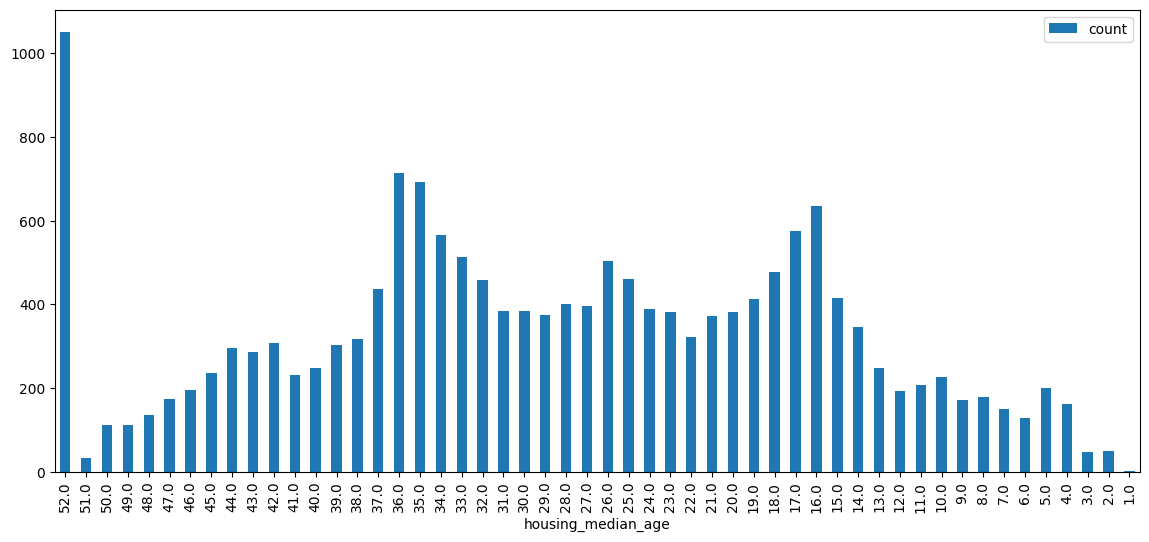

In [73]:
housing_median_age_df.toPandas().plot.bar(x="housing_median_age", figsize=(14, 6))

Как и в Pandas, в Spark тоже есть функция `describe`, которая выдает статистику по столбцам.

In [74]:
housing_df.describe().show()

+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|          longitude|          latitude|housing_median_age|      total_rooms|   total_bedrooms|        population|       households|     median_income|median_house_value|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              17000|             17000|             17000|            17000|            17000|             17000|            17000|             17000|             17000|
|   mean|-119.56210823529375|  35.6252247058827| 28.58935294117647|2643.664411764706|539.4108235294118|1429.5739411764705|501.2219411764706| 3.883578100000021|207300.91235294117|
| stddev| 2.0051664084260357|2.1373397946570867|12.586936981660406|2179.947071452777|421.4994515798648| 1

Также вы можете использовать `select` для манипулирования данными. Давайте для большей наглядности отобразим все числа до 4 знака, воспользовавшись функцией `round` 
из `pyspark.sql.functions`.

Изучите подробнее [документацию](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html) по этому модулю, так как он содержит полно полезных функций.

In [75]:
housing_df \
    .describe() \
    .select(
        "summary",
        F.round("housing_median_age", 4).alias("housing_median_age"),
        F.round("total_rooms", 4).alias("total_rooms"),
        F.round("total_bedrooms", 4).alias("total_bedrooms"),
        F.round("population", 4).alias("population"),
        F.round("households", 4).alias("households"),
        F.round("median_income", 4).alias("median_income"),
        F.round("median_house_value", 4).alias("median_house_value"),
    ) \
    .show()

+-------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|summary|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+-------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  count|           17000.0|    17000.0|       17000.0|   17000.0|   17000.0|      17000.0|           17000.0|
|   mean|           28.5894|  2643.6644|      539.4108| 1429.5739|  501.2219|       3.8836|       207300.9124|
| stddev|           12.5869|  2179.9471|      421.4995|  1147.853|  384.5208|       1.9082|       115983.7644|
|    min|               1.0|        2.0|           1.0|       3.0|       1.0|       0.4999|           14999.0|
|    max|              52.0|    37937.0|        6445.0|   35682.0|    6082.0|      15.0001|          500001.0|
+-------+------------------+-----------+--------------+----------+----------+-------------+------------------+



## Подготовка данных к обучению

Наша целевая колонка - медианная стоимость дома `median_house_value`. Чтобы упростить работу с ней, давайте будем исчислять в 1000000.

Чтобы выполнять преобразования надо колонками необходимо использовать `withColumn`, которое либо добавляет новый столбец, либо заменяет старый.
Все зависит от первого параметра. Вторым параметром идет выражение для колонки.

In [20]:
housing_df = housing_df.withColumn("median_house_value", col("median_house_value") / 100000)

In [21]:
housing_df.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|             0.669|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|             0.801|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 2 rows



In [22]:
housing_df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

Давайте добавим несколько новых признаков:

* `rooms_per_households` - отношение количества комнат на количество домов.
* `population_per_households` - отношение количества кжителей на количество домов.
* `bedrooms_per_room` - отношение количества спален к количеству комнат.

In [23]:
housing_df = housing_df \
    .withColumn("rooms_per_households", F.round(col("total_bedrooms") / col("households"), 2)) \
    .withColumn("population_per_households", F.round(col("population") / col("households"), 2)) \
    .withColumn("bedrooms_per_room", F.round(col("total_bedrooms") / col("total_rooms"), 2))

In [24]:
housing_df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+-------------------------+-----------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|rooms_per_households|population_per_households|bedrooms_per_room|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+-------------------------+-----------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|             0.669|                2.72|                     2.15|             0.23|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|             0.801|                4.11|                     2.44|             0.25|
|  -114.56|   33.69|              17.0|      720.0|         174.0

Отберем признаки для обучения.

In [25]:
housing_df = housing_df.select(
    "median_house_value",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_households",
    "population_per_households",
    "bedrooms_per_room",
)

In [26]:
feature_cols = [
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_households",
    "population_per_households",
    "bedrooms_per_room",
]

При помощи `VectorAssembler`объединим колонки в вектор признаков и запишем его в колонку `features`.

In [27]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [28]:
assembled_df = assembler.transform(housing_df)

In [29]:
assembled_df.show(10, truncate=False)

+------------------+--------------+----------+----------+-------------+--------------------+-------------------------+-----------------+--------------------------------------------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_per_households|population_per_households|bedrooms_per_room|features                                    |
+------------------+--------------+----------+----------+-------------+--------------------+-------------------------+-----------------+--------------------------------------------+
|0.669             |1283.0        |1015.0    |472.0     |1.4936       |2.72                |2.15                     |0.23             |[1283.0,1015.0,472.0,1.4936,2.72,2.15,0.23] |
|0.801             |1901.0        |1129.0    |463.0     |1.82         |4.11                |2.44                     |0.25             |[1901.0,1129.0,463.0,1.82,4.11,2.44,0.25]   |
|0.857             |174.0         |333.0     |117.0     |1.6509       |1.49               

При помощи `StandardScaler` промасштабируем наши вектора признаков.

In [30]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [31]:
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [32]:
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
|features                                    |features_scaled                                                                                                                         |
+--------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+
|[1283.0,1015.0,472.0,1.4936,2.72,2.15,0.23] |[3.043894826413315,0.8842596012848164,1.2275017368353283,0.7827450136369047,5.561631784929747,0.5324656112057998,3.9740715588081668]    |
|[1901.0,1129.0,463.0,1.82,4.11,2.44,0.25]   |[4.510088904919495,0.983575457980845,1.2040959833787224,0.9538001639121362,8.403789204434288,0.6042865541126285,4.319642998704529]      |
|[174.0,333.0,117.0,1.6509,1.49,2.85,0.24]   |[0.4128119250163031,0.290106844559

`randomSplit` отличается от scikit-learn тем, что в качестве параметра принимает веса для выборок.

In [33]:
train_data, test_data = scaled_df.randomSplit([.8, .2], seed=42)

In [34]:
train_data.columns

['median_house_value',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_households',
 'population_per_households',
 'bedrooms_per_room',
 'features',
 'features_scaled']

## Обучение

В качестве модели выберем модель линейной регрессии `LinearRegression`, в которой необходимо указать настройки обучения:

* колонка с вектором признаков `featuresCol`;
* колонка с метками `labelCol`;
* колонка для записи предсказаний `predictionCol`;
* и др. параметры модели

In [35]:
linear_regression = LinearRegression(
    featuresCol="features_scaled",
    labelCol="median_house_value",
    predictionCol="prediction_median_house_value",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    standardization=False,
)

Обучаем.

In [36]:
linear_regression_model = linear_regression.fit(train_data)

23/12/04 13:11:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Давайте посмотрим на параметры модели для каждого признака плюс для смещения.

In [37]:
coefficient = {"intercept": linear_regression_model.intercept}
for col, coef in zip(feature_cols, linear_regression_model.coefficients.toArray()):
    coefficient[col] = coef
for item in coefficient.items():
    print(item[0], item[1])

intercept 0.9869759715354963
total_bedrooms 0.0
population 0.0
households 0.0
median_income 0.5343694126364452
rooms_per_households 0.0
population_per_households 0.0
bedrooms_per_room 0.0


Запишем предсказания для тестового набора

In [38]:
predictions = linear_regression_model.transform(test_data)

In [39]:
predictions_and_labels = predictions.select("prediction_median_house_value", "median_house_value")

In [40]:
predictions_and_labels.show()

+-----------------------------+------------------+
|prediction_median_house_value|median_house_value|
+-----------------------------+------------------+
|            1.575070163876581|           0.14999|
|           1.2086874820480853|             0.225|
|           1.2270024154667076|              0.25|
|           1.7259863354254432|               0.3|
|           1.2856998167594178|             0.342|
|           1.2470816314623532|             0.366|
|           1.5295628751835209|             0.388|
|           1.6980378590465668|               0.4|
|            1.559415656566168|             0.421|
|            1.137080013009221|             0.425|
|           1.4508142623805147|             0.425|
|           1.3825393270982498|             0.425|
|           1.3370320384051895|             0.425|
|             1.34030856319109|             0.427|
|           1.2504141652189527|             0.436|
|           1.5872241105182967|              0.44|
|            1.267020825031251|

## Оценка модели

Модель можно оценить либо с помощью встроенных в модель функций-метрик.

In [41]:
print("RMSE: {0}".format(linear_regression_model.summary.rootMeanSquaredError))

RMSE: 0.884506278377271


In [42]:
print("MAE: {0}".format(linear_regression_model.summary.meanAbsoluteError))

MAE: 0.6816085980734734


In [43]:
print("R2: {0}".format(linear_regression_model.summary.r2))

R2: 0.420780332666955


Можно оценить качество модели регрессии при помощи `RegressionEvaluator`, указав колонки с меткой, предсказанием и название метрики.

In [44]:
evaluator = RegressionEvaluator(predictionCol="prediction_median_house_value", labelCol='median_house_value', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predictions_and_labels)))

RMSE: 0.8574242179175352


In [45]:
evaluator = RegressionEvaluator(predictionCol="prediction_median_house_value", labelCol='median_house_value', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predictions_and_labels)))

MAE: 0.6587587813790874


In [46]:
evaluator = RegressionEvaluator(predictionCol="prediction_median_house_value", labelCol='median_house_value', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predictions_and_labels)))

R2: 0.4438663878697524


Для старого формата `RDD` используется `RegressionMetrics`.

In [47]:
metrics = RegressionMetrics(predictions_and_labels.rdd)

/usr/local/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [48]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.8574242179175352


In [49]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6587587813790874


In [50]:
print("R2: {0}".format(metrics.r2))

R2: 0.4438663878697524


Больше о пакете Spark ML можно посмотреть на официальной странице с [документацией](https://spark.apache.org/docs/preview/api/python/pyspark.ml.html).

In [51]:
spark.stop()